# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [1]:
!git clone https://github.com/DataHow/analytics-course-scripts.git

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 348 (delta 71), reused 73 (delta 35), pack-reused 236
Receiving objects: 100% (348/348), 5.49 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [2]:
# import libaries
import pandas as pd
import numpy as np
import scipy
import copy
import importlib  
import scipy.integrate
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# import custom modules
simulator = importlib.import_module("analytics-course-scripts.scripts.modules.simulator")
modelhelpers = importlib.import_module("analytics-course-scripts.scripts.modules.modelhelpers")

# Import or Generate Dataset

In the beginning of each notebook you can make a decision whether you run the notebooks with already pre-generated runs which will be just imported or you will generate your own doe dataset from insilico model. For further information about the process emulator for cell culture fed-batch processes, check the script "00_Process_Characterization.ipynb" or the Powerpoint presentation "Simplified InSilico Model.pptx".

* For dataset import set `select_dataset_source = "import"`.
* For generating data set `select_dataset_source = "generate"`.

For first time running the notebook, we recommend choosing the "import" option.

 

In [3]:
""" Select dataset source, one of (import, generate) """
DATASET_SOURCE = "import"

In [4]:
if DATASET_SOURCE == "import":
    # Define filename to import
    FILENAME = "owu.csv"
    FILEPATH = "/content/analytics-course-scripts/scripts/datasets/"
    # Import OWU data
    doe = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    owu = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])
    # Import OWU Test data
    FILENAME = "owu_test.csv"
    doe_test = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    owu_test = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu_test.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])

In [5]:
if DATASET_SOURCE == "generate":
    # DOE Dataset definition (variable = [lower bound, upper bound]) 
    # Model parameters: Dictate the behaviour of the cell process
    MU_G_MAX = 0.05;
    MU_D_MAX = 0.025;
    K_G_GLC  = 1;
    K_I_LAC  = 30;
    K_D_LAC  = 50;
    K_GLC    = 0.04;
    K_LAC    = 0.06;
    K_PROD   = 1;
    # Process parameters: Conditions at which process is run
    FEED_START = [1, 4]
    FEED_END = [8, 12]
    GLC_FEED_RATE = [5, 20]
    GLC_0 = [10, 80.0]
    VCD_0 = [0.1, 1.0]
    # Number of experiments to generate
    NUM_RUNS = 40
    # Filename and filepath for the dataset 
    FILENAME = "owu.csv"
    FILEPATH = "/content/"
    # Collect parameters to dictionary
    VAR_LIMS = {"mu_g_max":MU_G_MAX, "mu_d_max": MU_D_MAX, "K_g_Glc" : K_G_GLC, "K_I_Lac" : K_I_LAC, "K_d_Lac" : K_D_LAC, "k_Glc" : K_GLC, "k_Lac" : K_LAC, "k_Prod" : K_PROD,
        "feed_start" : FEED_START,"feed_end" : FEED_END, "Glc_feed_rate" : GLC_FEED_RATE, "Glc_0" : GLC_0, "VCD_0" : VCD_0}
    # Generate Dataset
    data = simulator.generate_data(VAR_LIMS, NUM_RUNS, FILENAME)
    # Import DOE
    doe = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    # Import OWU
    owu = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(NUM_RUNS)),list(range(15))], names=["run","time"])

# Regression Modelling

In this section, we first load / import the train and test experiments that were created in the Process_Characterization script. Alternatively you can generate your own training data using generate option. 

These experimental data will be used to create models with the aim of predicting the final titer. 

Several different types of models will be considered.
* *Initial Conditions Model*: takes only the process condition and initial conditions as inputs. Black box type model, which disregards the process behaviour and consideres only outcome.
* *Historical Model*: takes full process history into account as inputs. This model however needs to be able to handle high-dimensional & colinear data.

# Initial Conditions Models

From OWU train and test dataset we create BWU data, DOE data and Target data.
DOE data contains the inditial parameter conditions (or Z variable) for the experiments.
Target data contain just the final values of Titer at day 14 (or Aggregates).

In [6]:
# Train set
bwu = simulator.generate_bwu(owu)
tar = simulator.generate_y(bwu,return_aggr=False)
# Test set
bwu_test = simulator.generate_bwu(owu_test)
tar_test = simulator.generate_y(bwu_test,return_aggr=False)

In [7]:
# Visualize input data and output data
dataset = copy.copy(doe) # inputs
dataset["Target"] = tar # outputs
dataset

,feed_start,feed_end,Glc_feed_rate,Glc_0,VCD_0,Target
0,2.500000,10.000000,12.500000,45.000000,0.550000,1565.310032
1,1.948980,10.244898,18.622449,40.714286,0.274490,854.449233
2,3.295918,9.346939,14.642857,17.857143,0.127551,1206.096655
3,3.479592,9.020408,15.561224,47.857143,0.843878,1587.937536
4,1.459184,9.591837,7.295918,33.571429,0.421429,811.55299
5,3.418367,9.265306,8.214286,45.000000,0.403061,841.498708
6,1.153061,8.448980,17.091837,67.857143,0.862245,645.86524
7,2.438776,8.122449,14.336735,10.714286,0.898980,978.32119
8,2.744898,11.551020,9.132653,27.857143,0.292857,1026.259363
9,2.316327,9.183673,5.459184,75.000000,0.256122,1307.342791


## Multiple Linear Regression 

We first train/fit a Linear Regression model to the final titer, using the data loaded above.

We then characterize the performance of the model using ANOVA, where the user can have information about the importance of each coefficient and of the overal model.

### Create linear model with preprocessing

Here we create a linear model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

In [8]:
# Fit Linear Model
datascaler = StandardScaler()
does = datascaler.fit_transform(doe.values)

X = sm.add_constant(does)
y = tar.values
mod = sm.OLS(y.astype(float), X.astype(float))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     3.240
Date:                Wed, 09 Nov 2022   Prob (F-statistic):             0.0141
Time:                        14:34:00   Log-Likelihood:                -357.18
No. Observations:                  50   AIC:                             726.4
Df Residuals:                      44   BIC:                             737.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1153.5475     46.179     24.980      0.0

Where the description/interpretation of some items in the table is as follows:
* R-squared : the coefficient of determination. It is the proportion of the variance in the dependent variable that is predictable/explained
* Adj. R-squared : Adjusted R-squared is the modified form of R-squared adjusted for the number of independent variables in the model. Value of adj. R-squared increases, when we include extra variables which actually improve the model.
* F-statistic : the ratio of mean squared error of the model to the mean squared error of residuals. It determines the overall significance of the model.
* coef : the coefficients of the independent variables and the constant term in the equation.
* t : the value of t-statistic. It is the ratio of the difference between the estimated and hypothesized value of a parameter, to the standard error

### Model Training and Inference

In this section, we fit a different linear model that is more flexible regarding the inputs. We mainly check the predictions of the models versus the training data for the final titer.


In [11]:
""" Normalize data """
USE_NORMALIZATION = True
""" Ploynomial degree of features """
USE_POLYDEGREE = 1
""" Add only interaction between features"""
USE_INTERACTIONSONLY = True

In [12]:
# Define pipeline
poly_features = PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)
standard_scaler = StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)
lm_model = LinearRegression()
pipe = Pipeline([('features', poly_features), 
                 ('scaler', standard_scaler),
                 ('model', lm_model)])
# Fit model
X = doe
y = tar
pipe.fit(X,y)

# Model Features and Coefficients
X_columns = poly_features.get_feature_names_out()
lm_coefficients = lm_model.coef_
# Model Std Error and p-values (not via sklearn)
X_preproc = pd.DataFrame(pipe.steps[1][1].transform(pipe.steps[0][1].transform(X)),columns=X_columns)
ols_model = sm.OLS(y.values.astype(float), sm.add_constant(X_preproc).values.astype(float)).fit()
ols_coefficients = ols_model.params[1:]
if X_preproc.shape[1]<X_preproc.shape[0]:
  ols_stderror = ols_model.bse[1:]
  ols_pvalue = ols_model.pvalues[1:].round(4)
else:
  print("\n !!!!! Model is overspecified !!!!! \n Results in perfect fit and unreliable coefficients  \n")
  ols_stderror = None
  ols_pvalue = None
# Plot Model Inference
fig = px.bar(x=list(X_columns),
             y=ols_coefficients.reshape(-1), 
             title="Linear model coefficients",
             labels={'x':"Variables", 'y':"Estimated Coefficients",'color':"p-value"}, 
             error_y=ols_stderror,
             color=ols_pvalue)
fig.show()


### Evaluate model prediction on train and test set

In [13]:
# Make predictions
yhat = pipe.predict(X)
X_test = doe_test
y_test = tar_test
yhat_test = pipe.predict(X_test)

# Calculate error metrics
train_r2 = round(pipe.score(X,y),3)
train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
test_r2 = round(pipe.score(X_test,y_test),3)
test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

# Plot observed vs predicted
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
    f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
# Train set plot
fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
# Test set plot
fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
fig.update_layout(title_text = "Observed vs Predicted Values")
fig.show()


### Model Diagnostics Plots

There are four main assumptions associated with a linear regression model:

* Linearity: The relationship between X and the mean of Y is linear.
* Homoscedasticity: The variance of residual is the same for any value of X.
* Independence: Observations are independent of each other.
* Normality: Errors are normally distributed.

These can by verified by so called diagnostics plots

In [14]:
# Quantities and Statistics necessary for Diagnostic Plots
model_X = pipe.steps[1][1].transform(pipe.steps[0][1].transform(X))
model_y = y.values.reshape(-1)
model_fitted_y = ols_model.fittedvalues
model_residuals = ols_model.resid
model_residuals_trendline = sm.nonparametric.lowess(exog=model_fitted_y, endog=model_residuals)
model_norm_residuals = ols_model.get_influence().resid_studentized_internal
model_norm_qq = stats.probplot(model_norm_residuals, dist="norm")
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
model_norm_residuals_abs_sqrt_trendline = sm.nonparametric.lowess(exog=model_fitted_y, endog=model_norm_residuals_abs_sqrt)
model_abs_resid = np.abs(model_residuals)
model_leverage = ols_model.get_influence().hat_matrix_diag
model_leverage_trendline = sm.nonparametric.lowess(exog=model_leverage, endog=model_norm_residuals)

In [15]:
# Diagnostic Plots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Residulas vs Fitted", "Normal Q-Q Plot", "Scale-Location", "Residuals vs Leverage"))
fig.add_trace(go.Scatter(x=model_fitted_y, y=model_residuals, mode="markers",text=X.index.get_level_values(0),name="run_id",marker=dict(color='blue')),row=1,col=1)
fig.add_trace(go.Scatter(x=model_residuals_trendline[:,0], y=model_residuals_trendline[:,1], mode="lines",line=dict(dash='dash'),name='trendline'),row=1,col=1)
fig.add_hline(y=0,row=1,col=1)
fig.update_xaxes(title_text="Fitted Values", row=1, col=1)
fig.update_yaxes(title_text="Residuals", row=1, col=1)
fig.add_trace(go.Scatter(x=model_norm_qq[0][0], y=model_norm_qq[0][1],mode='markers',marker=dict(color='blue'),name='norm_resid'),row=1,col=2)
fig.add_shape(type='line',x0=min(model_norm_qq[0][0]),y0=min(model_norm_qq[0][0]),x1=max(model_norm_qq[0][0]),y1=max(model_norm_qq[0][0]),layer='below',row=1,col=2)
fig.update_xaxes(title_text="Theoretical Quantiles", row=1, col=2)
fig.update_yaxes(title_text="Standardized Residuals", row=1, col=2)
fig.add_trace(go.Scatter(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, mode="markers",text=X.index.get_level_values(0),name="run_id",marker=dict(color='blue')),row=2,col=1)
fig.add_trace(go.Scatter(x=model_norm_residuals_abs_sqrt_trendline[:,0], y=model_norm_residuals_abs_sqrt_trendline[:,1], mode="lines",line=dict(dash='dash',color='red'),name='trendline'),row=2,col=1)
fig.update_xaxes(title_text="Fitted Values", row=2, col=1)
fig.update_yaxes(title_text="Sqrt of | Standardized Residuals |", row=2, col=1)
fig.add_trace(go.Scatter(x=model_leverage, y=model_norm_residuals, mode="markers",text=X.index.get_level_values(0),name="run_id",marker=dict(color='blue')),row=2,col=2)
fig.add_trace(go.Scatter(x=model_leverage_trendline[:,0], y=model_leverage_trendline[:,1], mode="lines",line=dict(dash='dash'),name='trendline'),row=2,col=2)
xgrid=np.linspace(0.1,max(model_leverage),30)
fig.add_trace(go.Scatter(x=xgrid, y=np.sqrt((0.5 * len(ols_model.params) * (1 - xgrid)) / xgrid), mode="lines",line=dict(dash='dot',color='red'),name='Cooks dist 0.5'),row=2,col=2)
xgrid=np.linspace(0.2,max(model_leverage),30)
fig.add_trace(go.Scatter(x=xgrid, y=np.sqrt((1 * len(ols_model.params) * (1 - xgrid)) / xgrid), mode="lines",line=dict(dash='dot',color='darkred'),name='Cooks dist 1'),row=2,col=2)
fig.update_xaxes(title_text="Leverage", row=2, col=2)
fig.update_yaxes(title_text="Standardized Residuals", row=2, col=2)

fig.update_layout(height=900,showlegend=False,title="Diagnostic Plots")
fig.show()


Interpretation of Diagnostic Plots

* **Residuals vs Fitted**: This graph shows if there are any nonlinear patterns in the residuals, and thus in the data as well. One of the mathematical assumptions in building an OLS model is that the data can be fit by a line. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted. An ideal Residuals vs Fitted plot will look like random noise; there won’t be any apparent patterns in the scatterplot and the red line would be horizontal.

* **Normal Q-Q Plot**: This plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. If there are  several points that fall far away from the diagonal line. This is indicative of the errors not being normally distributed. The model can suffer from “heavy tails”, "skweness", etc.

* **Scale-Location**: This plot is a way to check if the residuals suffer from non-constant variance, aka heteroscedasticity. The more horizontal the red line is, the more likely the data is homoscedastic. 

* **Residuals vs Leverage**: Unlike outliers, which have an unusually large y value, leverage points have extreme x values. This can have damaging effects on the model because the β coefficients are very sensitive to leverage points. Here we can identify problematic observations. Points that have Cook's distance lager then 0.5 are considered leverage points.

## Model Comparison

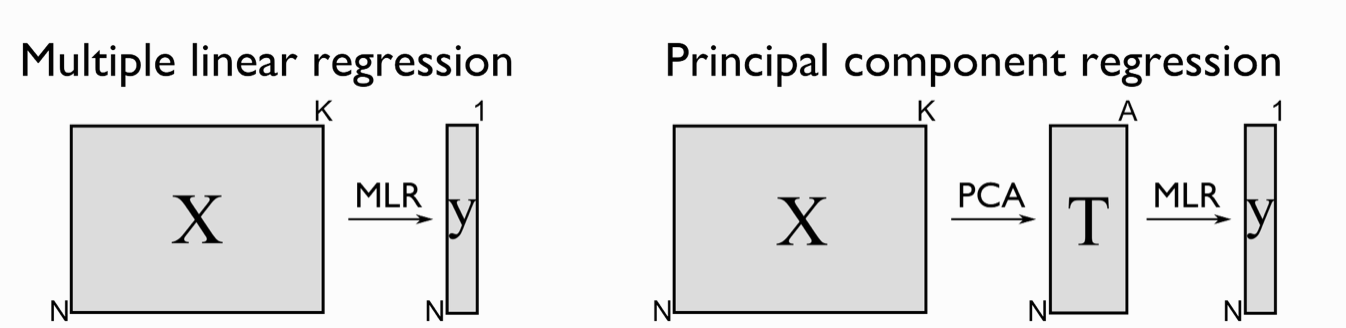

### Partial Least Squares

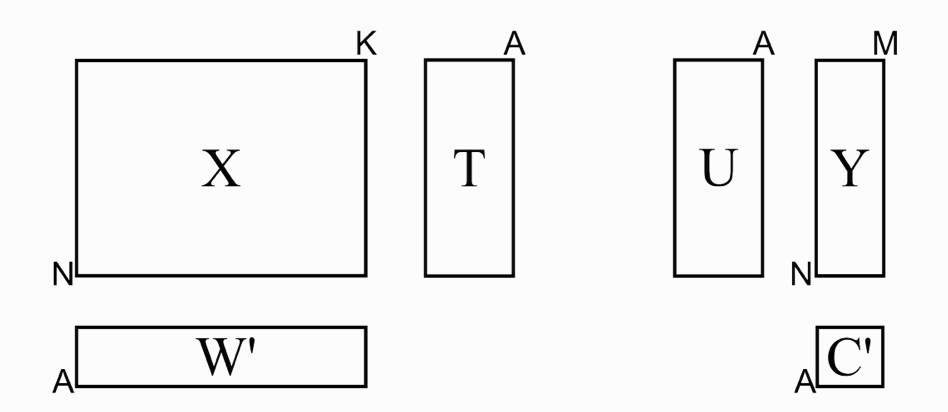

In PLS, we also find these latent variables, but we find them so they best explain $X$ and best explain $Y$, and so that these latent variables have the strongest possible relationship between $X$ and $Y$.

## PLS Model

In this section, we keep the same data structure but we train a PLS model. PLS model allows us to use more variables/columns without the model being overspecified.

In a case of single response $y$ and $k$ predictors, PLS regression model with $h$ latent variables is expressed as follows.

$ X = T W^t + E$

$ y = U c^t +f$

The VIP score is a summary of the importance for the projections to find $h$ latent variables. It's calculated for $j-th$ variable as 
$ VIP_j = (k \sum_i^h (SS(c_i t_i)(w_{ij} / ||{w_i}||)^2) / \sum_k^h(c_i t_i))^{1/2}$
Since the average of squared VIP scores equals 1, 'greather than one rule' is generally used as criterion for variable selection.

### Create a PLS model with specific latent variables

Create a PLS model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

Select the number of latent variables for the model (the maximum number of latent variables is 5, equal to the number of variables in the input matrix).





In [30]:
""" Number of latent Variables """
USE_LV = 20
""" Normalize data """
USE_NORMALIZATION = True
""" Ploynomial degree of features """
USE_POLYDEGREE = 1
""" Add only interaction between features"""
USE_INTERACTIONSONLY = True

In [31]:
# Define pipeline
poly_features = PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)
standard_scaler = StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)
pls_model = PLSRegression(n_components=USE_LV,scale=False)
pipe = Pipeline([('features', poly_features), 
                 ('scaler', standard_scaler),
                 ('model', pls_model)])
# Fit PLS model
X = doe
y = tar
pipe.fit(X,y)
# Model features and variable importance 
X_columns = poly_features.get_feature_names_out()
X_preproc = pd.DataFrame(pipe.steps[1][1].transform(pipe.steps[0][1].transform(X)),columns=X_columns)
pls_vip = modelhelpers.vip(X_preproc,y,pls_model)
# Plot Model Inference
fig = px.bar(x=list(X_columns),
             y=pls_vip.reshape(-1), 
             title="VIP scores of PLS model",
             labels={'x':"Variables", 'y':"Estimated VIP",'color':"p-value"})
fig.add_hline(y=1)
fig.add_hline(y=0.8,line=dict(color='gray'))
fig.show()


### Evaluate model on train and test set


In [32]:
# Make predictions
yhat = pipe.predict(X)
X_test = doe_test
y_test = tar_test
yhat_test = pipe.predict(X_test)

# Calculate error metrics
train_r2 = round(pipe.score(X,y),3)
train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
test_r2 = round(pipe.score(X_test,y_test),3)
test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

# Plot observed vs predicted
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
    f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
# Train set plot
fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
# Test set plot
fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
fig.update_layout(title_text = "Observed vs Predicted")
fig.show()


In [33]:
""" Principal component on x-axis and y-axis """
PC_X_AXIS = 1
PC_Y_AXIS = 2


In [34]:
fig = make_subplots(rows=2, cols=2,     specs=[[{"colspan": 2}, None],[{}, {}]],subplot_titles=("Scores Plot ","Loadings of Principal Component - "+str(PC_X_AXIS),"Loadings of Principal Component - "+str(PC_Y_AXIS)))
fig.add_trace(go.Scatter(x=pls_model.x_scores_[:,PC_X_AXIS],y=pls_model.x_scores_[:,PC_Y_AXIS],mode='markers',name='Scores'),row=1,col=1)
fig.add_bar(x=X_columns, y=pls_model.x_loadings_[:,PC_X_AXIS-1], name='Loadings PC - ' + str(PC_X_AXIS),row=2, col=[1,2])
fig.add_bar(x=X_columns, y=pls_model.x_loadings_[:,PC_Y_AXIS-1], name='Loadings PC - ' + str(PC_Y_AXIS),row=2, col=2)
fig.update_layout(height=1000)

### Hyperparameter Optimization in Cross Validation

In this section, we will simulate a typical cross- validation to define the optimal number of latent variables.

Nfold PLS models are trained using (Nfolds-1) folds. Each model is then evaluated on the remaining unused fold. This is repeated for different numbers of latent variables. The number of latent variables returning the least value of the RMSE is chosen as optimal.

In [36]:
range_LV = range(1, X_preproc.shape[1]+1)
train_eval, valid_eval = validation_curve(pipe, X, y, param_name = "model__n_components", param_range=list(range_LV),scoring = 'neg_root_mean_squared_error')
train_score=-np.mean(train_eval,axis=1)
valid_score=-np.mean(valid_eval,axis=1)
train_std = np.std(train_eval,axis=1)
valid_std = np.std(valid_eval,axis=1)
fig = go.Figure()
fig.add_trace(go.Scatter( x=list(range_LV), y=train_score, error_y=dict(type='data',array=train_std,visible=True), name="Training"))
fig.add_trace(go.Scatter( x=list(range_LV), y=valid_score, error_y=dict(type='data',array=valid_std,visible=True), name="Validation"))
fig.update_layout(title="Hyperparameter Optimization in PLS",xaxis_title="Number of Latent Variables",yaxis_title="RMSE",legend_title="Evaluation type")
fig.show()


# Historical Model

In an so-called historical model, the data from different experiments are ordered into a batch-wise unfolded (BWU) matrix (i.e., every row corresponds to an experiment).

The BWU can be used to compute final properties of the experiment, like CQAs, which are typically the effect of the cumulated effect of the experiment profile.

In this example, we will use the BWU matrix to predict the final value of titer. Clearly, titer information are removed from the BWU matrix.



## Multiple Linear Model

Unlinke in the initial conditions model, there are several problems in using an linear regression / response surface model for modelling historical data. The main problem is that MLR requires our dataset $X$ (the BWU data) to have more rows (samples) than columns (variables). Second is that if $X^T X$ has full rank due only to noise, the inverse is unstable and small changes in noise realization can produce dramatically different results.

If we look at the shape of our BWU matrix, that it already has 75 variables and only 50 samples which makes it dificult to fit linear model.

In [37]:
bwu.shape

(50, 75)

## Historical PLS Model 

We demonstrate that with more information and more variables, the PLS becomes a model with good predictions and low RMSEP.

### Create BWU matrix

Here the BWU matrix is created. The vaues of the manipulated variables are added as columns at the beginning of the matrix. The following pre-processing was performed.

* Remove titer (and also lactate)
* Remove exceeding days
* Eliminate invariant columns
* Remove linearly dependent columns
* Add process parameters at the beginning
* Create a PLS model from the initial design to the final titer


In [38]:
""" Number of days of process history """
USE_DAYS = 13
""" Remove variables """
REMOVE_VARS = ['Feed','Titer','Lac']
""" Number of latent variables """
N_LV = 5
""" Normalize data """
USE_NORM = True

In [39]:
# Create and preprocess bwu matrix
X_bwu = bwu
remove_columns = []
# Remove Variables
if 'Titer' in REMOVE_VARS:
    remove_columns.extend([c for c in bwu.columns if c.startswith('X:Titer')])
if 'Lac' in REMOVE_VARS:
    remove_columns.extend([c for c in bwu.columns if c.startswith('X:Lac')])
if 'Feed' in REMOVE_VARS:
    remove_columns.extend([c for c in bwu.columns if c.startswith('W:Feed')])
if 'Glc' in REMOVE_VARS:
    remove_columns.extend([c for c in bwu.columns if c.startswith('X:Glc')])
if 'VCD' in REMOVE_VARS:
    remove_columns.extend([c for c in bwu.columns if c.startswith('X:VCD')])
# Remove History
for d in range(USE_DAYS,15):
    remove_columns.extend([c for c in bwu.columns if c.endswith(':0')])
    remove_columns.extend([c for c in bwu.columns if c.endswith(":"+str(d))])
# Remove Invariant 
remove_columns.extend(list(bwu.columns[~(bwu != bwu.iloc[0]).any().values]))
# Add and remove columns
X_preproc = pd.concat([doe, X_bwu.drop(set(remove_columns),axis=1)], axis=1)
print(X_preproc.columns)

Index(['feed_start', 'feed_end', 'Glc_feed_rate', 'Glc_0', 'VCD_0', 'X:VCD:1',
       'X:VCD:2', 'X:VCD:3', 'X:VCD:4', 'X:VCD:5', 'X:VCD:6', 'X:VCD:7',
       'X:VCD:8', 'X:VCD:9', 'X:VCD:10', 'X:VCD:11', 'X:VCD:12', 'X:Glc:1',
       'X:Glc:2', 'X:Glc:3', 'X:Glc:4', 'X:Glc:5', 'X:Glc:6', 'X:Glc:7',
       'X:Glc:8', 'X:Glc:9', 'X:Glc:10', 'X:Glc:11', 'X:Glc:12'],
      dtype='object')


### Train & Evaluate model on train and test set




In [40]:
# Define Pipeline
pscaler = StandardScaler(with_mean=USE_NORM,with_std=USE_NORM)
pls_bwu = PLSRegression(n_components=N_LV)
pipe = Pipeline([('scaler', pscaler), ('pls', pls_bwu)])
# Train PLS model
y = tar
X = X_preproc
X_columns = X.columns
pipe.fit(X,y)

# Make predictions
yhat = pipe.predict(X)
X_test = pd.concat([doe_test, bwu_test.drop(set(remove_columns),axis=1)], axis=1)
y_test = tar_test
yhat_test = pipe.predict(X_test)

# Calculate error metrics
train_r2 = round(pipe.score(X,y),3)
train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
test_r2 = round(pipe.score(X_test,y_test),3)
test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

# Plot observed vs predicted
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
    f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
# Train set plot
fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
# Test set plot
fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
fig.update_layout(title_text = "Observed vs Predicted",showlegend=False)
fig.show()


In [41]:
""" Principal component on x-axis and y-axis """
PC_X_AXIS = 1
PC_Y_AXIS = 2


In [42]:
fig = make_subplots(rows=2, cols=2,     specs=[[{"colspan": 2}, None],[{}, {}]],subplot_titles=("Scores Plot ","Loadings of Principal Component - "+str(PC_X_AXIS),"Loadings of Principal Component - "+str(PC_Y_AXIS)))
fig.add_trace(go.Scatter(x=pls_bwu.x_scores_[:,PC_X_AXIS],y=pls_bwu.x_scores_[:,PC_Y_AXIS],mode='markers',name='Scores'),row=1,col=1)
fig.add_bar(x=X_columns, y=pls_bwu.x_loadings_[:,PC_X_AXIS-1], name='Loadings PC - ' + str(PC_X_AXIS),row=2, col=[1,2])
fig.add_bar(x=X_columns, y=pls_bwu.x_loadings_[:,PC_Y_AXIS-1], name='Loadings PC - ' + str(PC_Y_AXIS),row=2, col=2)
fig.update_layout(height=1000)

In [43]:
pls_bwu_vip = modelhelpers.vip(X,y,pls_bwu)
# Plot Model Inference
fig = px.bar(x=list(X_columns),
             y=pls_bwu_vip.reshape(-1), 
             title="VIP scores of PLS model",
             labels={'x':"Variables", 'y':"Estimated VIP",'color':"p-value"})
fig.add_hline(y=1)
fig.add_hline(y=0.8,line=dict(color='gray'))
fig.show()

### Hyperparameter Optimization in Cross Validation


In this section, we will simulate a typical cross- validation to define the optimal number of latent variables.


Nfold PLS models are trained using (Nfolds-1) folds. For each model, the sum of squared residuals (SSR) is calculated and summed up..

This is repeated for different numbers of latent variables. The number of latent variables returning the least value of the RMSE is chosen as optimal.
A second criterion is selected, namely the adjusted R-squared (adj. R^2), which is weighting the effect of the number of latent variables, i.e., if two values of the number of latent variables are returning a similar value of the SSR, then the one using less variables is chosen to be more likely to produce robust predictions.:


In [44]:
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=5))])

In [46]:
range_LV = range(1, X.shape[1]+1)
train_eval, valid_eval = validation_curve(pipe, X, y, param_name = "pls__n_components", param_range=list(range_LV),scoring = 'neg_root_mean_squared_error')
train_score=-np.mean(train_eval,axis=1)
valid_score=-np.mean(valid_eval,axis=1)
train_std = np.std(train_eval,axis=1)
valid_std = np.std(valid_eval,axis=1)
fig = go.Figure()
fig.add_trace(go.Scatter( x=list(range_LV), y=train_score, error_y=dict(type='data',array=train_std,visible=True), name="Training"))
fig.add_trace(go.Scatter( x=list(range_LV), y=valid_score, error_y=dict(type='data',array=valid_std,visible=True), name="Validation"))
fig.update_layout(title="Hyperparameter Optimization in PLS",xaxis_title="Number of Latent Variables",yaxis_title="RMSE",legend_title="Evaluation type")
fig.show()


# Task: 

1. What is the optimal number of latent variables to use for Historical PLS model
2. Check model diagnostics by plotting residuals and verify if the modelling assumptions are satisfied.
